### Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.linear_model import LogisticRegression,LinearRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc,r2_score


### Analise Dos Dados

In [2]:
df_vinho_branco = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';', quotechar='"', encoding='utf-8')
df_vinho_branco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [3]:
# verificando os dados ausentes NaN
percent_missing = (df_vinho_branco.isnull().sum() / df_vinho_branco.shape[0]) * 100

print(percent_missing)

fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
quality                 0.0
dtype: float64


In [4]:
# Criar uma cópia para não alterar o dataframe original
df_vinho_branco = df_vinho_branco.copy()

# 1. Corrigir valores ausentes corretamente
for col in df_vinho_branco.columns:
    if df_vinho_branco[col].dtype == 'float64':
        df_vinho_branco[col] = df_vinho_branco[col].fillna(df_vinho_branco[col].median())  # Preencher com a mediana

# 2. Função de pré-processamento corrigida
def preprocessamento(df):
    df_proc = df.copy()
    le = LabelEncoder()
    
    for col in df_proc.columns:
        if df_proc[col].dtype == 'object':  # Apenas colunas categóricas
            df_proc[col] = le.fit_transform(df_proc[col])
    
    return df_proc

df_vinho_branco_proc = preprocessamento(df_vinho_branco)

# 3. Criar nova variável categórica para qualidade do vinho
bins = [2, 4, 6, 8]  # Aumentei para cobrir todos os valores
labels = ['Baixa', 'Média', 'Alta']
df_vinho_branco_proc['qualidade_categoria'] = pd.cut(df_vinho_branco_proc['quality'], bins=bins, labels=labels, right=True)

# 4. Exibir os primeiros valores para verificar
print(df_vinho_branco_proc.head())

# Verificar se os valores foram corretamente atribuídos
print(df_vinho_branco_proc['qualidade_categoria'].value_counts())


   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality qualidade_categoria  
0      8.8        6               Média  
1 

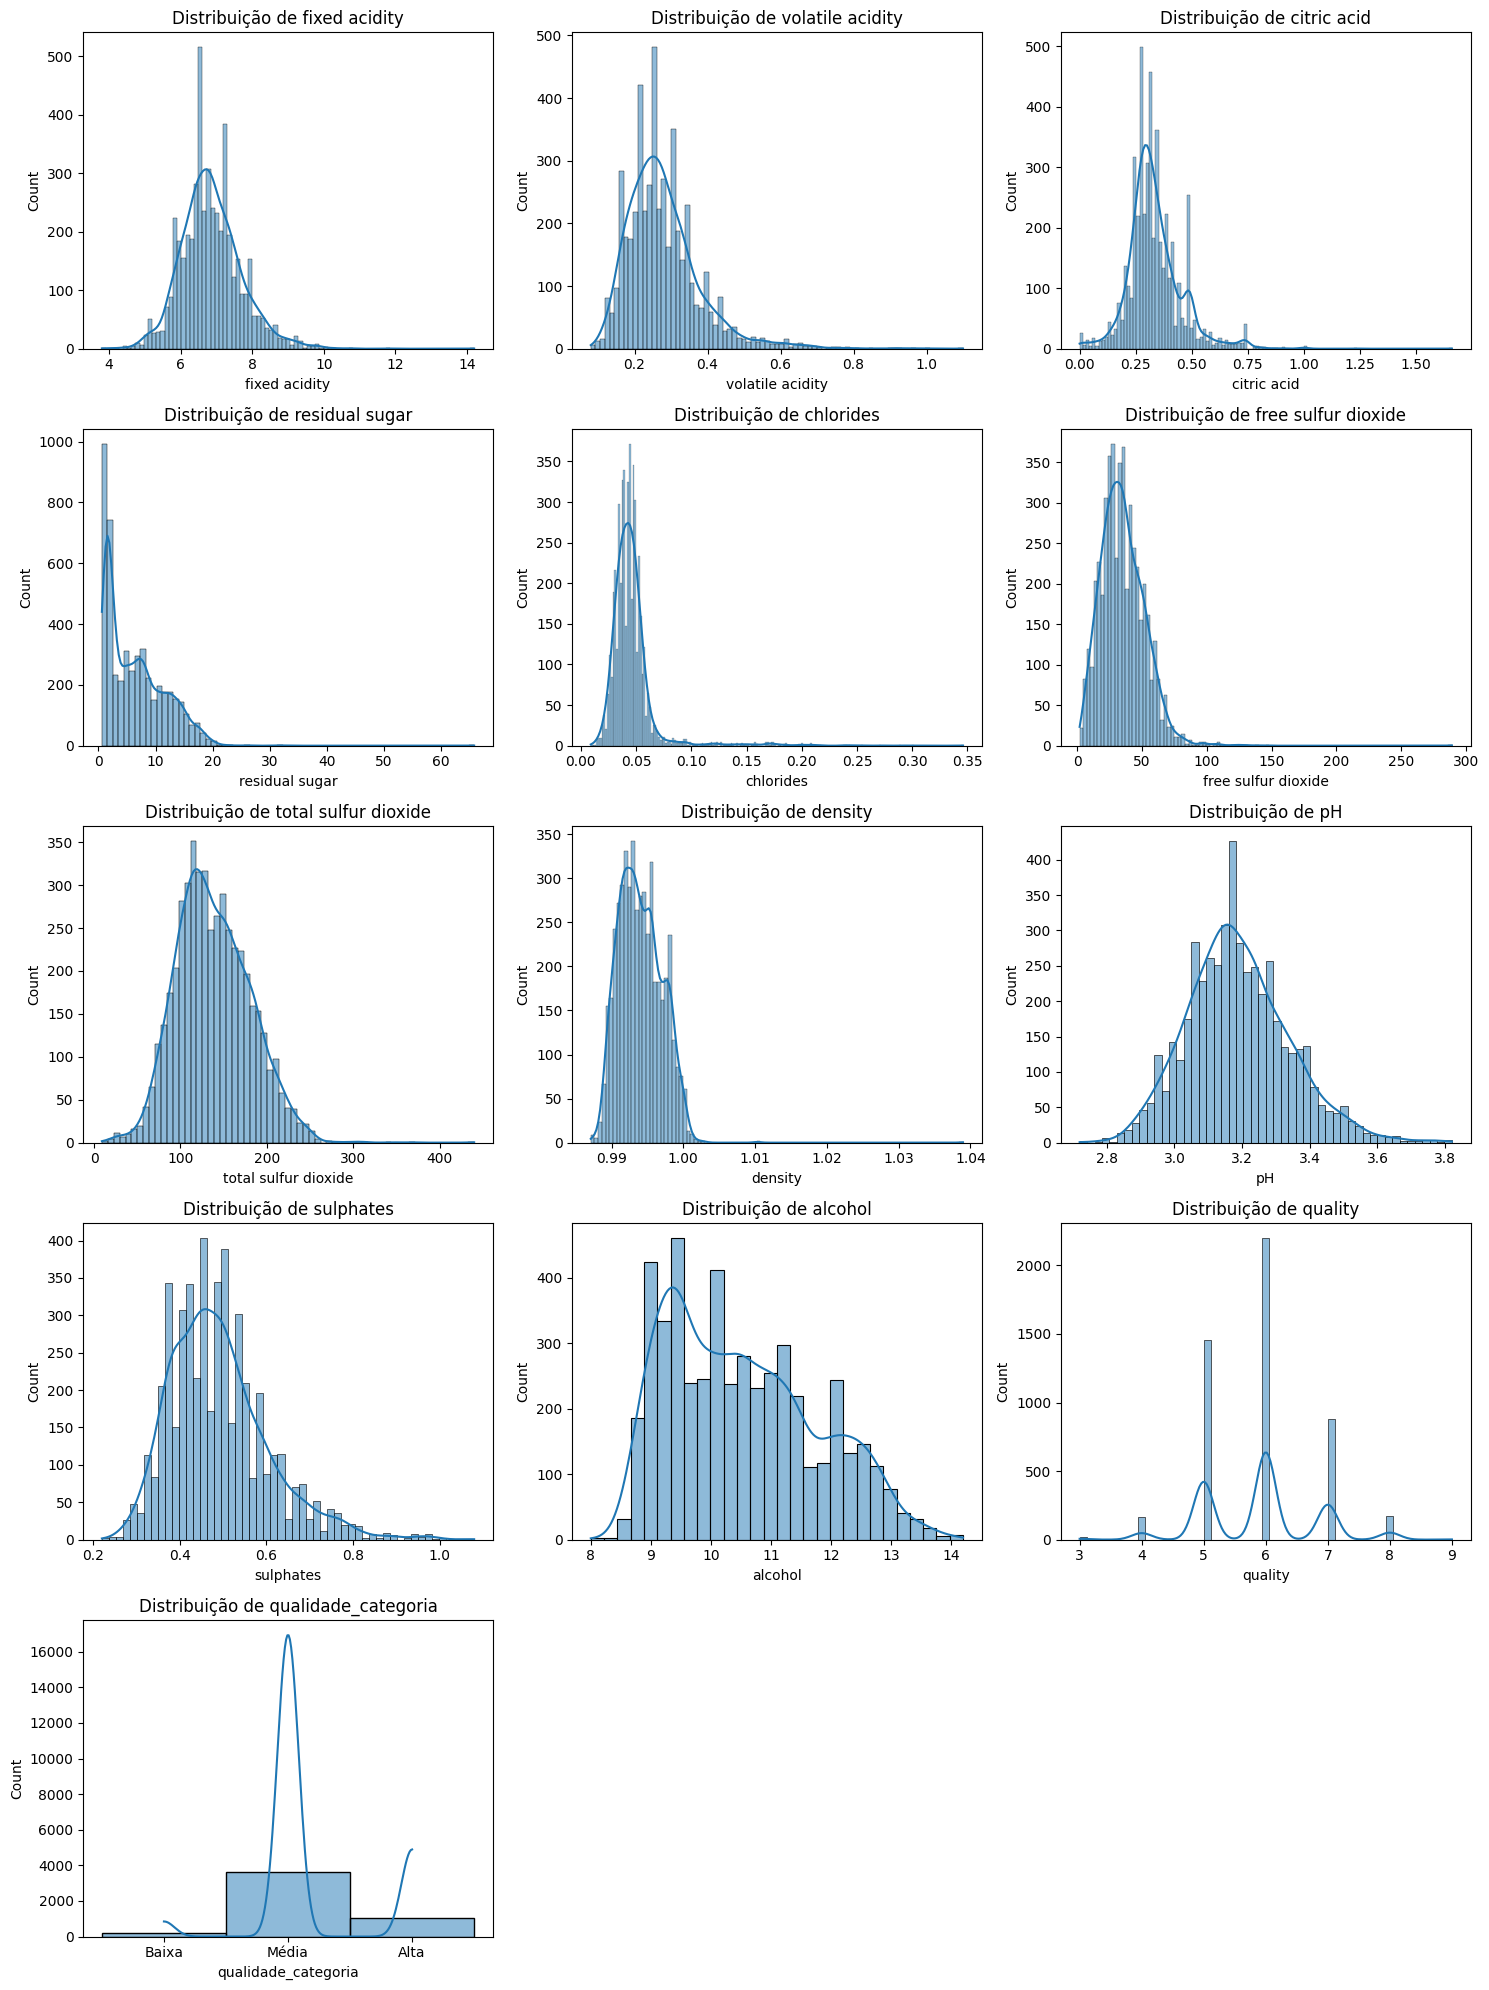

In [5]:
# Grafico de distribuição das notas de qualidade

num_colunas = len(df_vinho_branco_proc.columns)

# Calcular número de linhas necessário (supondo 3 colunas por linha)
num_linhas = math.ceil(num_colunas / 3)

# Criar a figura
plt.figure(figsize=(15, num_linhas * 4))

# Criar os subplots
for i, col in enumerate(df_vinho_branco_proc.columns, 1):
    if i > 15:
        break  # Limitar a 15 gráficos
    
    plt.subplot(num_linhas, 3, i)  # Ajuste dinâmico
    sns.histplot(df_vinho_branco_proc[col], kde=True)
    plt.title(f'Distribuição de {col}')

plt.tight_layout()
plt.show()

### Treinando Modelos

In [6]:
# Transformando em X e y passando o Treinamento

X = df_vinho_branco_proc.drop(columns=['quality', 'qualidade_categoria'], axis=1)
y = df_vinho_branco_proc['qualidade_categoria']

# Transformar y (classe categórica em valores numéricos)
le = LabelEncoder()
y = le.fit_transform(y)

# Normalizar X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
   
# Dividindo os dados em conjuntos de treino e teste 80 para treino e 20 para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Avaliando os Modelos

In [11]:
# Testar diferentes valores de K para o KNN Classificador
k_values = range(1, 21)
accuracies = []

for k in k_values:
    modelo = KNeighborsClassifier(n_neighbors=k)
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Melhor K para classificação
melhor_k = k_values[np.argmax(accuracies)]

# Modelos de Classificação
modelos_clf = [
    ('Regressão Logística', LogisticRegression(max_iter=1000)),
    ('Árvore de Decisão', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('KNN', KNeighborsClassifier(n_neighbors=melhor_k))
]

# Avaliação dos modelos de Classificação
resultados_clf = []
for nome, modelo in modelos_clf:
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred) * 100
    precisao = precision_score(y_test, y_pred, average='macro', zero_division=1) * 100
    recall = recall_score(y_test, y_pred, average='macro', zero_division=1) * 100
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=1) * 100
    
    resultados_clf.append((nome, acuracia, precisao, recall, f1))

# Ordenar os resultados por F1-score
resultados_clf_ordenados = sorted(resultados_clf, key=lambda x: x[3], reverse=True)

# Exibir os resultados da Classificação
print("\n📊 Resultados - Modelos de Classificação Vinho Branco :")
print(f"{'Modelo':<25} {'Acurácia':<10} {'Precisão':<10} {'Recall':<10} {'F1-Score':<10}")
for nome, acuracia, precisao, recall, f1 in resultados_clf_ordenados:
    print(f"{nome:<25} {acuracia:.2f}%    {precisao:.2f}%    {recall:.2f}%    {f1:.2f}%")

# Agora para os modelos de Regressão
y_reg = df_vinho_branco_proc['quality']  # Usamos a qualidade como valor contínuo

# Divisão treino/teste para regressão
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)

# Modelos de Regressão
modelos_reg = [
    ('Regressão Linear', LinearRegression()),
    ('Árvore de Decisão Regressor', DecisionTreeRegressor(random_state=42)),
    ('Random Forest Regressor', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('KNN Regressor', KNeighborsRegressor(n_neighbors=melhor_k))
]

# Avaliação dos modelos de Regressão
resultados_reg = []
media_y_test = np.mean(y_test)  # Média de y_test para normalizar os erros

for nome, modelo in modelos_reg:
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    mae = (mean_absolute_error(y_test, y_pred) / media_y_test) * 100
    mse = (mean_squared_error(y_test, y_pred) / media_y_test) * 100
    r2 = r2_score(y_test, y_pred) * 100  # Já está normalizado, apenas convertendo para %

    resultados_reg.append((nome, mae, mse, r2))

# Ordenar os resultados da regressão pelo menor MAE
resultados_reg_ordenados = sorted(resultados_reg, key=lambda x: x[1])

# Exibir os resultados da Regressão
print("\n📊 Resultados - Modelos de Regressão Vinho Branco :")
print(f"{'Modelo':<30} {'MAE (%)':<10} {'MSE (%)':<10} {'R² (%)':<10}")
for nome, mae, mse, r2 in resultados_reg_ordenados:
    print(f"{nome:<30} {mae:.2f}%    {mse:.2f}%    {r2:.2f}%")


📊 Resultados - Modelos de Classificação Vinho Branco :
Modelo                    Acurácia   Precisão   Recall     F1-Score  
Árvore de Decisão         60.71%    35.67%    52.60%    36.63%
KNN                       64.59%    52.35%    51.42%    51.48%
Random Forest             68.98%    74.66%    45.40%    49.23%
Regressão Logística       53.06%    44.84%    36.34%    22.30%

📊 Resultados - Modelos de Regressão Vinho Branco :
Modelo                         MAE (%)    MSE (%)    R² (%)    
Random Forest Regressor        7.09%    5.90%    55.05%
KNN Regressor                  7.12%    9.64%    26.48%
Árvore de Decisão Regressor    8.23%    11.34%    13.57%
Regressão Linear               9.93%    9.64%    26.53%


<Figure size 1000x600 with 0 Axes>

/home/desktop_dev/Documentos/GitHub/BOOTCAMP_LLM/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


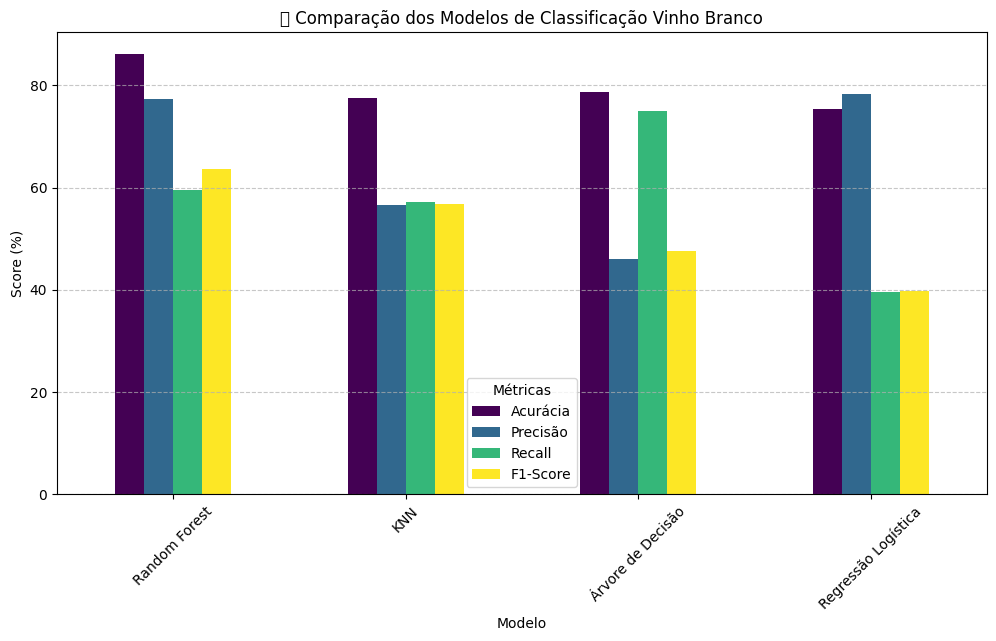

In [8]:
df_clf = pd.DataFrame(resultados_clf, columns=['Modelo', 'Acurácia', 'Precisão', 'Recall', 'F1-Score'])
df_clf = df_clf.sort_values(by='F1-Score', ascending=False)

# Plotar os resultados de Classificação
plt.figure(figsize=(10, 6))
df_clf.set_index('Modelo').plot(kind='bar', figsize=(12,6), colormap="viridis")
plt.title("📊 Comparação dos Modelos de Classificação Vinho Branco")
plt.ylabel("Score (%)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Métricas")
plt.show()


<Figure size 1000x600 with 0 Axes>

/home/desktop_dev/Documentos/GitHub/BOOTCAMP_LLM/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


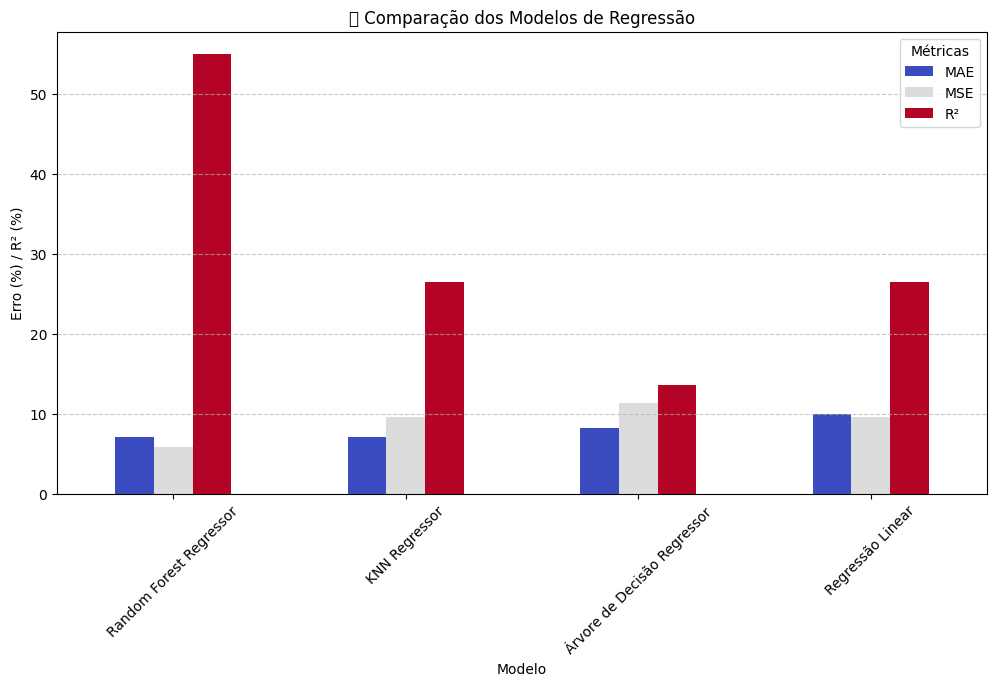

In [10]:
df_reg = pd.DataFrame(resultados_reg, columns=['Modelo', 'MAE', 'MSE', 'R²'])
df_reg = df_reg.sort_values(by='MAE')

# Plotar os resultados de Regressão
plt.figure(figsize=(10, 6))
df_reg.set_index('Modelo').plot(kind='bar', figsize=(12,6), colormap="coolwarm")
plt.title("📊 Comparação dos Modelos de Regressão")
plt.ylabel("Erro (%) / R² (%)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Métricas")
plt.show()